# Gamma Ray Reconstruction for the AdEPT Mission
### Spencer R. Deevy - deevys@mcmaster.ca

# Acknowledgements

##### Dr. Andrei Hanu - andrei.hanu@brucepower.com
A large portion of the code used in this notebook is derived from previous work on AdEPT code, written by Dr. Andrei Hanu.  
Dr. Hanu's code can be found alongside this notebook, and was last listed as "AdEPT_G4_Cellular_Automata_KDTree.ipynb"

##### Richard Garnett - garnetri@mcmaster.ca
Images used in this notebook were created by Richard Garnett.  
Future developers can obtain access to this simulation by contacting Richard Garnett through his Github account (garnetri)

# Import required libraries

In [19]:
# Matplotlib and other plotting libraries
from matplotlib import collections as mc
from matplotlib import pyplot as plt

import cv2                                              # OpenCV
import numpy as np                                      # Numpy
from enum import Enum                                   # Enums for flags
from math import *                                      # Math libraries
from palettable.colorbrewer.sequential import Greys_9_r # Colour map
from scipy.spatial import cKDTree                       # KD Tree

# Simulation Configuration

In [20]:
class Mode(Enum):
    IMAGE = 0
    STREAM = 1
    
mode = Mode.IMAGE  # Input is XZ and YZ projection images of Geant4 simulation
#mode = Mode.STREAM # Input is binary streaming data file

# Load Simulation Images from Geant4

In [21]:
# Image mode flag must be set
if(mode == Mode.IMAGE):
    print('Simulation Mode: [Image]')
    
    # Load the Geant4 simulation images (XZ and YZ projections)
    # Images needed to be flipped due to read-in method
    image_raw_XZ = np.flipud(cv2.imread('Data/Gamma Rays/AR_Gamma_20MeV_XZ.png', cv2.IMREAD_GRAYSCALE))
    image_raw_YZ = np.flipud(cv2.imread('Data/Gamma Rays/Gamma_01_YZ.png', cv2.IMREAD_GRAYSCALE))

    # Get shape of images
    rows_XZ, columns_XZ = image_raw_XZ.shape
    rows_YZ, columns_YZ = image_raw_YZ.shape

    # Find all of the detector hits (Pixel value > 0)
    hits_XZ = np.column_stack(np.where(np.transpose(image_raw_XZ) > 0))
    hits_YZ = np.column_stack(np.where(np.transpose(image_raw_YZ) > 0))

    # Sort detector hits (First by Z (Column 1), then by X/Y (Column 0))
    hits_XZ = hits_XZ[np.lexsort((hits_XZ[:, 0], hits_XZ[:, 1]))]
    hits_YZ = hits_YZ[np.lexsort((hits_YZ[:, 0], hits_YZ[:, 1]))]

Simulation Mode: [Image]


# Load Streaming Data from Binary File

In [22]:
# Stream mode flag must be set
if(mode == Mode.STREAM):
    print('Simulation Mode: [Stream]')
    
    # TODO: Read in variable volume snapshots from binary file

# Plot Raw Detector Images

Saving raw image of detector hits to: Detector_Hits_XZYZ.pdf


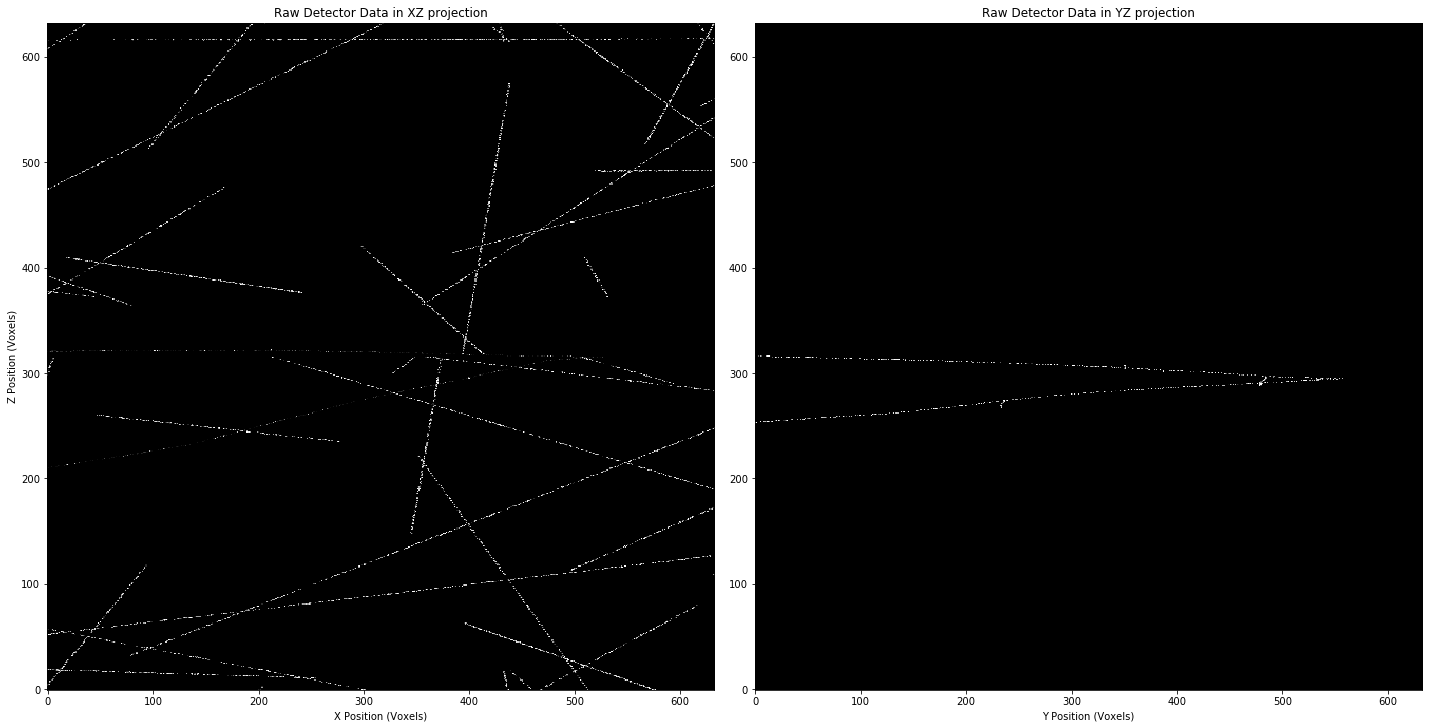

In [23]:
figure_raw, (ax_raw_XZ, ax_raw_YZ) = plt.subplots(1, 2, figsize=(20, 15))

cmap = Greys_9_r.mpl_colormap

# Plot the raw images; Plots neededed to be enhanced to produce visible plots
ax_raw_XZ.imshow(image_raw_XZ * 10, origin = 'lower', cmap = cmap, interpolation = 'nearest')
ax_raw_YZ.imshow(image_raw_YZ * 10, origin = 'lower', cmap = cmap, interpolation = 'nearest')

# No grid
ax_raw_XZ.grid(False)
ax_raw_YZ.grid(False)

# Set labels
ax_raw_XZ.set_xlabel('X Position (Voxels)')
ax_raw_YZ.set_xlabel('Y Position (Voxels)')
ax_raw_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_raw_XZ.set_title('Raw Detector Data in XZ projection')
ax_raw_YZ.set_title('Raw Detector Data in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_raw_XZYZ ='Detector_Hits_XZYZ.pdf'
plt.savefig(file_raw_XZYZ)
print('Saving raw image of detector hits to: ' + file_raw_XZYZ)

plt.show(figure_raw)

# Plot Detector Hits

Saving image of detector hits to: Detector_Hits_XZYZ.pdf


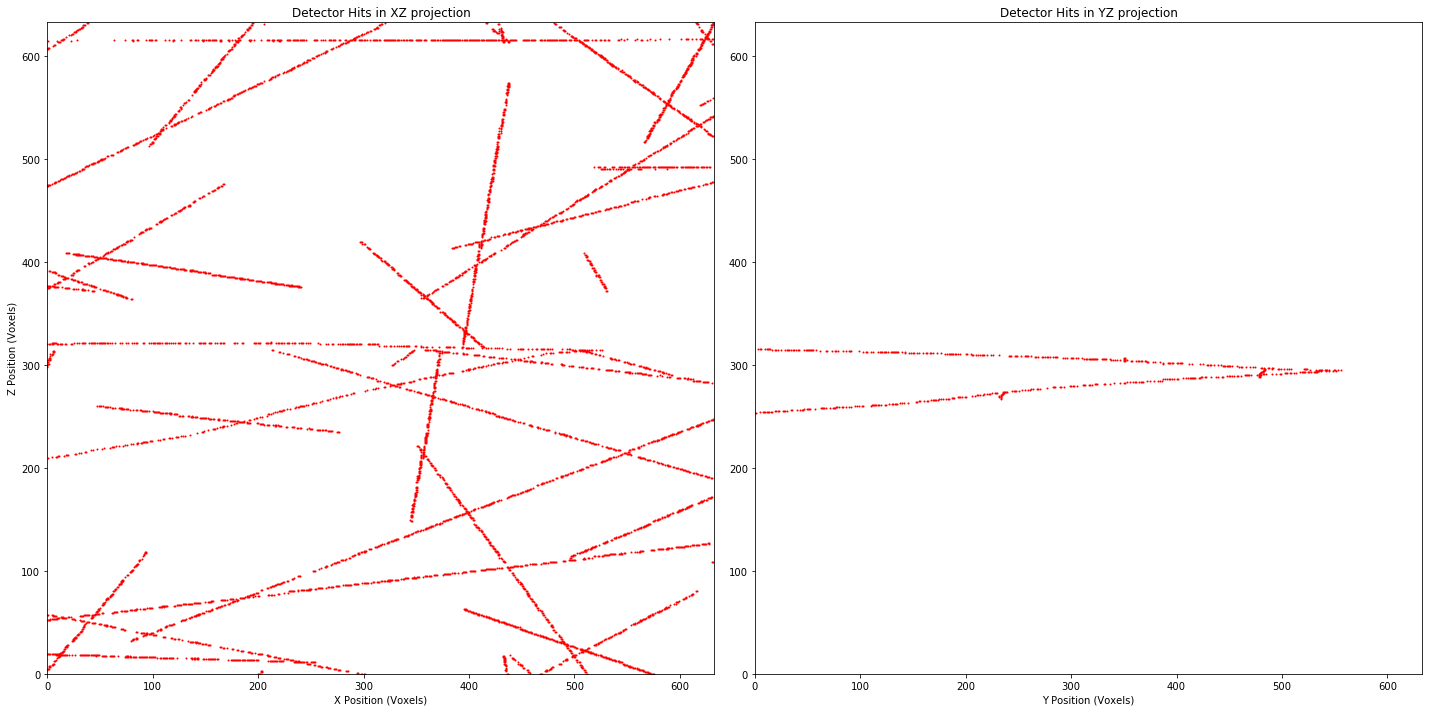

In [24]:
figure_hits, (ax_hits_XZ, ax_hits_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the detector hits
ax_hits_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_hits_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')

# Set axis limits
ax_hits_XZ.set_xlim(0, rows_XZ)
ax_hits_XZ.set_ylim(0, columns_XZ)
ax_hits_YZ.set_xlim(0, rows_YZ)
ax_hits_YZ.set_ylim(0, columns_YZ)

# Set labels
ax_hits_XZ.set_xlabel('X Position (Voxels)')
ax_hits_YZ.set_xlabel('Y Position (Voxels)')
ax_hits_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_hits_XZ.set_title('Detector Hits in XZ projection')
ax_hits_YZ.set_title('Detector Hits in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_hits_XZYZ ='Detector_Hits_XZYZ.pdf'
plt.savefig(file_hits_XZYZ)
print('Saving image of detector hits to: ' + file_hits_XZYZ)

plt.show(figure_hits)

# Build KD Tree of Detector Hits

In [25]:
# Insert XZ hits and YZ hits into repective KD trees
tree_XZ = cKDTree(hits_XZ, leafsize=15)
tree_YZ = cKDTree(hits_YZ, leafsize=15)

# Find Track Terminating Points

In [26]:
def findTerminatingPoints(hits_proj, tree_proj, type_proj):

    # Directional counters
    up = 0
    down = 0
    left = 0
    right = 0
    
    min_distance = 10000 # Distance measure used to filter for locality
    
    terminating_points = [] # Acceptable terminating points
    filtered_points = []    # Filtered terminating points for locality

    # Loop through each segment to check for local minimums
    for i in range(len(hits_proj)):
        # Current segment start point cannot have another point in radius with lower z value
        hits_near = hits_proj[tree_proj.query_ball_point(hits_proj[i], 10)]
        for (k, z) in hits_near:
            
            # Update directional counters
            if(z > hits_proj[i][1]):
                up += 1
            if(z < hits_proj[i][1]):
                down += 1
            if(k < hits_proj[i][0]):
                left += 1
            if(k > hits_proj[i][0]):
                right += 1
            
            # Candidate lower endpoint
            if(up >= 0.8 * len(hits_near) and down == 0):
                if(left >= 0.75 * len(hits_near)):
                    terminating_points.append(hits_proj[i]) # lower right endpoint
                if(right >= 0.75 * len(hits_near)):
                    terminating_points.append(hits_proj[i]) # lower left endpoint
                if(up - (left + right) > 1):
                    terminating_points.append(hits_proj[i]) # lower endpoint
            if(down >= 0.8 * len(hits_near) and up == 0):
                if(left >= 0.75 * len(hits_near)):
                    terminating_points.append(hits_proj[i]) # upper right endpoint
                if(right >= 0.75 * len(hits_near)):
                    terminating_points.append(hits_proj[i]) # upper left endpoint
                if(down - (left + right) > 1):
                    terminating_points.append(hits_proj[i]) # upper endpoint
            if(left >= 0.8 * len(hits_near) and right == 0):
                if(up >= 0.75 * len(hits_near)):
                    terminating_points.append(hits_proj[i]) # lower right endpoint
                if(down >= 0.75 * len(hits_near)):
                    terminating_points.append(hits_proj[i]) # upper right endpoint
                if(left - (up + down) > 1):
                    terminating_points.append(hits_proj[i]) # right endpoint
            if(right >= 0.8 * len(hits_near) and left == 0):
                if(up >= 0.75 * len(hits_near)):
                    terminating_points.append(hits_proj[i]) # lower left endpoint
                if(down >= 0.75 * len(hits_near)):
                    terminating_points.append(hits_proj[i]) # upper left endpoint
                if(right - (up + down) > 1):
                    terminating_points.append(hits_proj[i]) # left endpoint

        # Reset directional counters
        up = 0
        down = 0
        left = 0
        right = 0
        
    filtered_points.append(terminating_points[0]) # Add first terminating point to filtered list
    
    # Filter out terminating points that are too close to each other
    for i in range(1, len(terminating_points)):
        for j in range(len(filtered_points)):
            distance = sqrt((terminating_points[i][0] - filtered_points[j][0])**2
                            + (terminating_points[i][1] - filtered_points[j][1])**2)
            if(distance < min_distance):
                min_distance = distance
        if(min_distance >= 3):
            filtered_points.append(terminating_points[i])
        min_distance = 10000

    # Format and filter 
    #filtered_points = filtered_points[:][0:2]
    filtered_points = np.vstack({tuple(row) for row in filtered_points})
    print('Number of starting / ending points in ', type_proj, 'projection: [', len(filtered_points), ']')
    
    return filtered_points

In [27]:
terminate_XZ = findTerminatingPoints(hits_XZ, tree_XZ, 'XZ')
terminate_YZ = findTerminatingPoints(hits_YZ, tree_YZ, 'YZ')

Number of starting / ending points in  XZ projection: [ 62 ]
Number of starting / ending points in  YZ projection: [ 5 ]


# Plot Track Terminating Points

Saving image of terminating hits to: Terminating_Hits_XZYZ.pdf


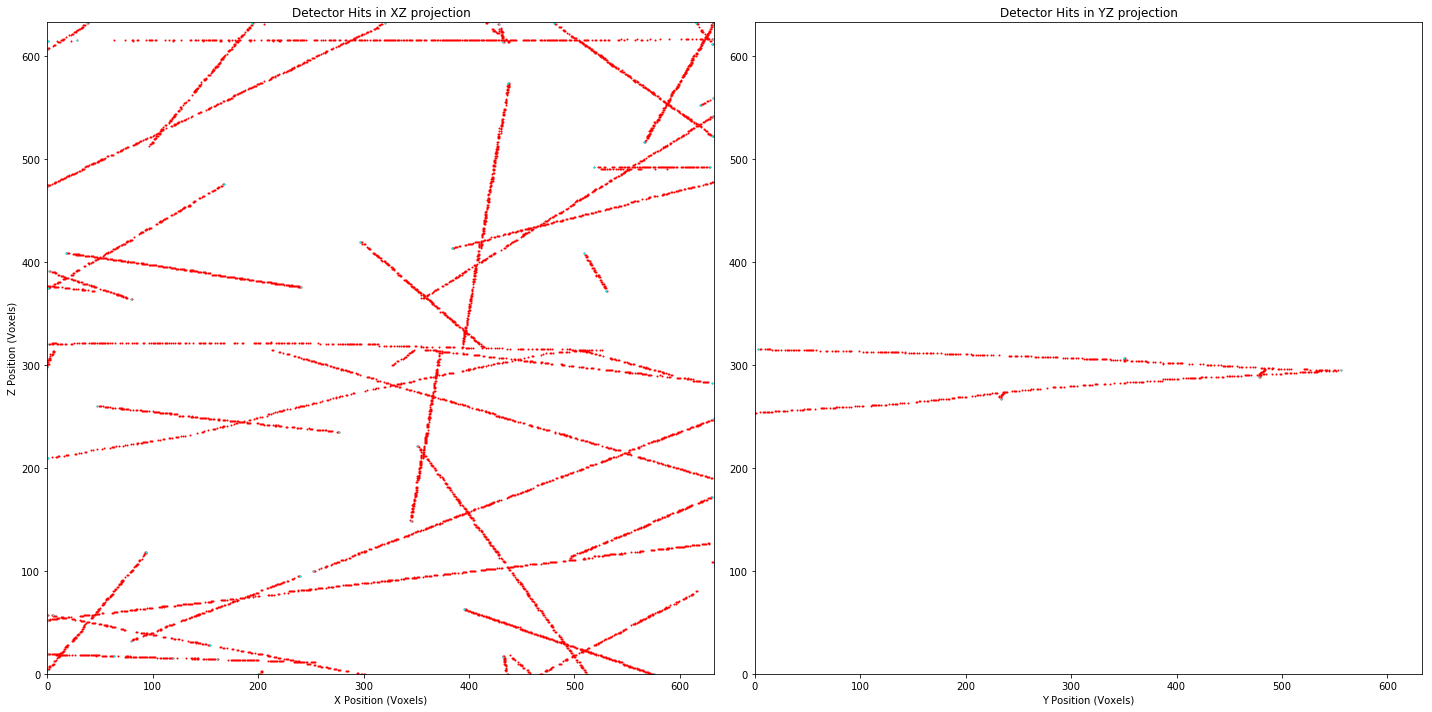

In [28]:
figure_terminate, (ax_terminate_XZ, ax_terminate_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the detector hits
ax_terminate_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_terminate_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')
ax_terminate_XZ.plot(terminate_XZ[:,0], terminate_XZ[:,1], '.', ms=2, color='cyan') 
ax_terminate_YZ.plot(terminate_YZ[:,0], terminate_YZ[:,1], '.', ms=2, color='cyan') 

# Set axis limits
ax_terminate_XZ.set_xlim(0, rows_XZ)
ax_terminate_XZ.set_ylim(0, columns_XZ)
ax_terminate_YZ.set_xlim(0, rows_YZ)
ax_terminate_YZ.set_ylim(0, columns_YZ)

# Set labels
ax_terminate_XZ.set_xlabel('X Position (Voxels)')
ax_terminate_YZ.set_xlabel('Y Position (Voxels)')
ax_terminate_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_terminate_XZ.set_title('Detector Hits in XZ projection')
ax_terminate_YZ.set_title('Detector Hits in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_terminate_XZYZ ='Terminating_Hits_XZYZ.pdf'
plt.savefig(file_terminate_XZYZ)
print('Saving image of terminating hits to: ' + file_terminate_XZYZ)

plt.show(figure_terminate)

# Initial Track Segment Generation

In [29]:
# Function to calculate the angle between two neighbouring track segments
#
# Expects two numpy ndarrays [proj_i z_i proj_f z_f] where:
# proj_i - starting x/y coordinate
# z_i    - starting z coordinate
# proj_f - final x/y coordinate
# z_f    - final z coordinate

def calcTrackSegmentAngle(segA, segB):
    # Create vectors
    vA = [(segA[2] - segA[0]), (segA[3] - segA[1])]
    vB = [(segB[2] - segB[0]), (segB[3] - segB[1])]
    
    # Calculate the dot product between the vectors
    dotvAvB = np.dot(vA, vB)
    
    # Calculate the magnitude of each vector
    magA = np.dot(vA, vA)**0.5
    magB = np.dot(vB, vB)**0.5
    
    # Return the angle in degrees
    return np.degrees(np.arccos(dotvAvB/(magA*magB)))

In [30]:
def findTracks(hits_proj, term_proj, tree_proj, proj_type):
    # Search radii bounds
    radius_minimum = 5
    radius_maximum = 10
    radius_step = 1
    
    # Acceptance angle for connected track segments (+/- degrees)
    angle_accept = 10
    
    tracks = [] # Empty list to store full tracks
    
    # Create shallow curve tracks for each terminating point
    for(proj, z) in term_proj:
        heading_point_groups = [] # Groups of points used to determine heading
        current_point_group = []  # Current group of points being constructed
        track_points = []         # List of points contained in track
        heading = []              # Averaged heading, using heading_points
        length = 0                # Initial max group length for like-segments
        index = 0                 # Initial index of largest group of like-segments
        proj_heading = 0          # Projection heading created from averaged heading point projection
        z_heading = 0             # Z heading created from averaged heading point z values
        heading_counter = 1       # Counter to determine if at the end of a track
        
        # Find nearest neighbours to use in constructing the heading
        heading_NN = hits_proj[tree_proj.query_ball_point([proj, z], radius_maximum)]
        
        # Build a group of like-segments for each nearest neighbour
        for(proj_NN, z_NN) in heading_NN:
            current_point_group.append(np.array([proj_NN, z_NN])) # Add current primary point to current point group
            primary_seg = np.array([proj, z, proj_NN, z_NN])      # Segment to use against other segments to find angle
        
            # Compare current segment against other segments
            for(proj_compare, z_compare) in heading_NN:
                if((proj_NN != proj_compare) and (z_NN != z_compare)):
                    compare_seg = np.array([proj, z, proj_compare, z_compare]) # Current comparing segment
                    
                    # Angle between primary segment and current segment is within acceptace
                    # Add compare point to primary point group
                    if(calcTrackSegmentAngle(primary_seg, compare_seg) < angle_accept):
                        current_point_group.append(np.array([proj_compare, z_compare]))
        
            heading_point_groups.append(current_point_group) # Add current group of points into total collection of point groups
            current_point_group = []  # Current group of points being constructed
            
        # Find largest heading group
        for i in range(len(heading_point_groups)):
            if(len(heading_point_groups[i]) > length):
                length = len(heading_point_groups[i])
                index = i
            
        # Add heading points to track points list   
        track_points.extend(heading_point_groups[index])
        
        # Find furthest heading point
        distance = 0
        for (proj_far, z_far) in heading_point_groups[index]:
            current_distance = sqrt((proj_far - proj)**2 + (z_far - z)**2)
            if(current_distance > distance):
                proj_farthest = proj_far
                z_farthest = z_far
                distance = current_distance
        
        # Create heading vector from initial heading points
        for (proj_head, z_head) in heading_point_groups[index]:
            proj_heading += proj_head
            z_heading += z_head
        proj_heading = proj_heading / len(heading_point_groups[index])
        z_heading = z_heading / len(heading_point_groups[index])
        
        # Heading vector, originating at furthest heading point
        heading_seg = np.array([proj_farthest, z_farthest, proj_farthest + (proj_heading - proj), z_farthest + (z_heading - z)]) 
        
        heading_counter = 1
        while(heading_counter != 0):
            
            heading_counter = 0 # Set heading counter to zero in anticipation of track ending
            heading_points = [] # Empty list to store new heading points; Used to find next heading point
            proj_heading = 0
            z_heading = 0
            proj_prev = proj_farthest
            z_prev = z_farthest
            
            # Find nearest neighbours to use in constructing the next heading
            heading_NN = hits_proj[tree_proj.query_ball_point([proj_farthest, z_farthest], radius_maximum*1.6)]

            # Compare current segment against other segments
            for(proj_compare, z_compare) in heading_NN:
                if((heading_seg[2] != proj_compare) and (heading_seg[3] != z_compare)):
                    
                    # Current comparing segment
                    compare_seg = np.array([heading_seg[0], heading_seg[1], proj_compare, z_compare])

                    # Angle between primary segment and current segment is within acceptace
                    # Add compare point to primary point group
                    if(calcTrackSegmentAngle(heading_seg, compare_seg) < 10):
                        heading_points.append(np.array([proj_compare, z_compare]))
                        heading_counter += 1
                        
            # Add new heading points to track points list and create new heading
            if(len(heading_points) > 0):
                # Create heading vector from heading points
                for (proj_head, z_head) in heading_points:
                    proj_heading += proj_head
                    z_heading += z_head
                proj_heading = proj_heading / len(heading_points)
                z_heading = z_heading / len(heading_points)

                # Find furthest heading point
                distance = 0
                for (proj_far, z_far) in heading_points:
                    current_distance = sqrt((proj_far - heading_seg[0])**2 + (z_far - heading_seg[1])**2)
                    if(current_distance > distance):
                        proj_farthest = proj_far
                        z_farthest = z_far
                        distance = current_distance

                # Heading vector, originating at furthest heading point
                heading_seg = np.array([proj_farthest, z_farthest, 
                                        proj_farthest + ((proj_heading - proj_prev) + 2*(heading_seg[2] - heading_seg[0]))/3, 
                                        z_farthest + ((z_heading - z_prev) + 2*(heading_seg[3] - heading_seg[1]))/3])  
                        
                track_points.extend(heading_points) # Add heading points to track points list
        
        # TODO: Scan entire track
        
        tracks.append(track_points) # Add all points to the track
        
        # Reset temporary lists and counters
        heading_point_groups = [] # Groups of points used to determine heading
        current_point_group = []  # Current group of points being constructed
        track_points = []         # List of points contained in track
        heading = []              # Averaged heading, using heading_points
        length = 0                # Initial max group length for like-segments
        index = 0                 # Initial index of largest group of like-segments
        proj_heading = 0          # Projection heading created from averaged heading point projection
        z_heading = 0             # Z heading created from averaged heading point z values
        heading_counter = 1       # Counter to determine if at the end of a track
        heading_points = [] # Empty list to store new heading points; Used to find next heading point
        
    for i in range(len(tracks)):
        tracks[i] = np.vstack(tracks[i])
        
    # Output some useful information
    print(proj_type + 'Z tracks:', len(tracks))

    return tracks

In [31]:
# Find XZ and YZ initial track segments
tracks_XZ = findTracks(hits_XZ, terminate_XZ, tree_XZ, 'X')
tracks_YZ = findTracks(hits_YZ, terminate_YZ, tree_YZ, 'Y')

C:\Users\deevy\Miniconda3\envs\AdEPT\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
C:\Users\deevy\Miniconda3\envs\AdEPT\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\deevy\Miniconda3\envs\AdEPT\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


XZ tracks: 62
YZ tracks: 5


# Plot Initial Track Segments

Saving image of track hits to: Track_Hits_XZYZ.pdf


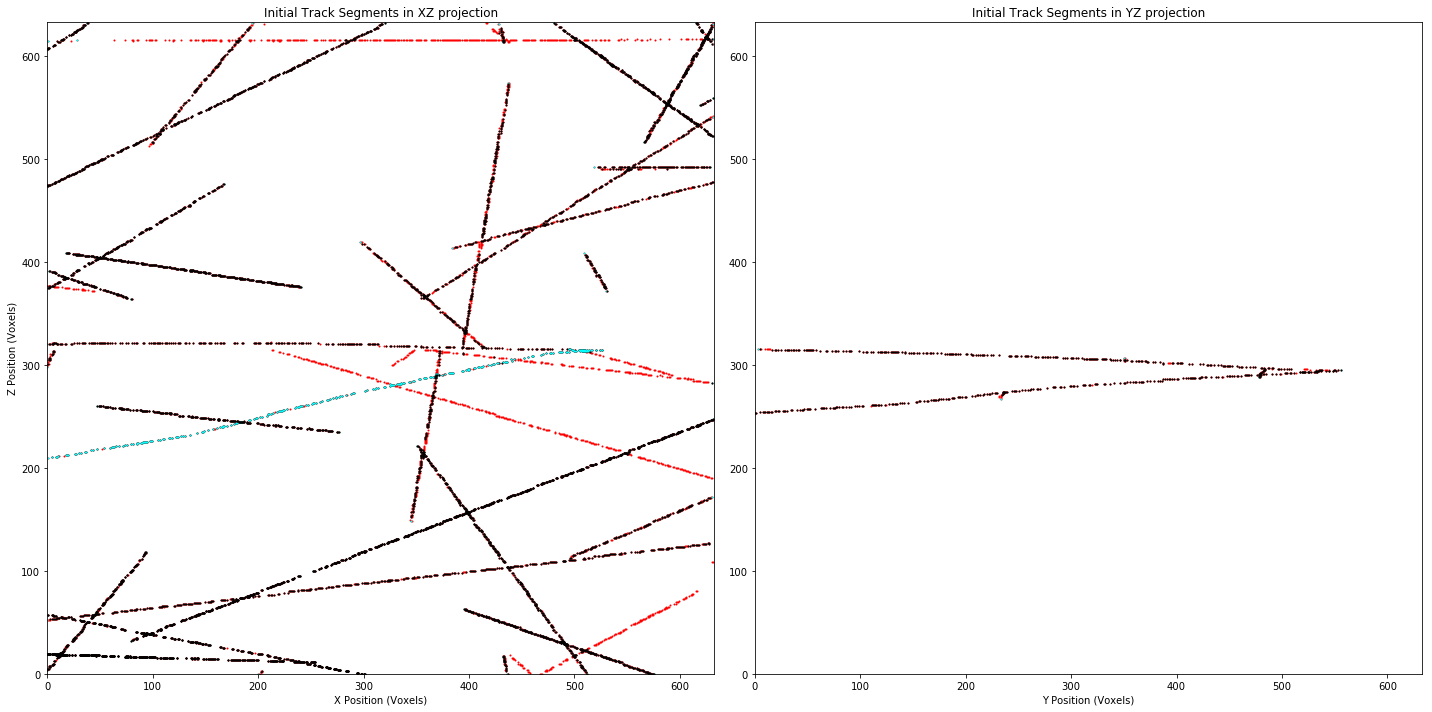

In [32]:
figure_init_segs, (ax_init_segs_XZ, ax_init_segs_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the detector hits
ax_init_segs_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_init_segs_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')
ax_init_segs_XZ.plot(terminate_XZ[:,0], terminate_XZ[:,1], '.', ms=2, color='cyan') 
ax_init_segs_YZ.plot(terminate_YZ[:,0], terminate_YZ[:,1], '.', ms=2, color='cyan')

# Plot track hits
for i in range(len(tracks_XZ)):
    ax_init_segs_XZ.plot(tracks_XZ[i][:,0], tracks_XZ[i][:,1], '.', ms=2, color='black')
    if(i == 25):
        ax_init_segs_XZ.plot(tracks_XZ[i][:,0], tracks_XZ[i][:,1], '.', ms=2, color='cyan')
for i in range(len(tracks_YZ)):
    ax_init_segs_YZ.plot(tracks_YZ[i][:,0], tracks_YZ[i][:,1], '.', ms=2, color='black')
    
# Set axis limits
ax_init_segs_XZ.set_xlim(0, rows_XZ)
ax_init_segs_XZ.set_ylim(0, columns_XZ)
ax_init_segs_YZ.set_xlim(0, rows_YZ)
ax_init_segs_YZ.set_ylim(0, columns_YZ)

# Set labels
ax_init_segs_XZ.set_xlabel('X Position (Voxels)')
ax_init_segs_YZ.set_xlabel('Y Position (Voxels)')
ax_init_segs_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_init_segs_XZ.set_title('Initial Track Segments in XZ projection')
ax_init_segs_YZ.set_title('Initial Track Segments in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_init_segs_XZYZ ='Track_Hits_XZYZ.pdf'
plt.savefig(file_init_segs_XZYZ)
print('Saving image of track hits to: ' + file_init_segs_XZYZ)

plt.show(figure_init_segs)

# Find Gamma Rays Amongst Shallow Tracks

In [36]:
candidates_XZ = []
indices_XZ = []
vertices_XZ = []
gammas_XZ = []
candidates_YZ = []
indices_YZ = []
vertices_YZ = []
gammas_YZ = []

# Search XZ projection for tracks that touch
for i in range(len(tracks_XZ)):
    for j in range(len(tracks_XZ)):
        if(i != j and i not in indices_XZ and j not in indices_XZ):
            dist0 = sqrt((tracks_XZ[i][0][0] - tracks_XZ[j][0][0])**2 + (tracks_XZ[i][0][1] - tracks_XZ[j][0][1])**2)
            dist1 = sqrt((tracks_XZ[i][0][0] - tracks_XZ[j][-1][0])**2 + (tracks_XZ[i][0][1] - tracks_XZ[j][-1][1])**2)
            dist2 = sqrt((tracks_XZ[i][-1][0] - tracks_XZ[j][0][0])**2 + (tracks_XZ[i][-1][1] - tracks_XZ[j][0][1])**2)
            dist3 = sqrt((tracks_XZ[i][-1][0] - tracks_XZ[j][-1][0])**2 + (tracks_XZ[i][-1][1] - tracks_XZ[j][-1][1])**2)
            
            if(dist0 < 1):
                if(dist3 > 50):
                    candidates_XZ.append(tracks_XZ[i])
                    candidates_XZ.append(tracks_XZ[j])
                    indices_XZ.append(i)
                    indices_XZ.append(j)
                    vertices_XZ.append(tracks_XZ[i][0])
            elif(dist1 < 1):
                if(dist2 > 50):
                    candidates_XZ.append(tracks_XZ[i])
                    candidates_XZ.append(tracks_XZ[j])
                    indices_XZ.append(i)
                    indices_XZ.append(j)
                    vertices_XZ.append(tracks_XZ[i][0])
                    
            elif(dist2 < 1):
                if(dist1 > 50):
                    candidates_XZ.append(tracks_XZ[i])
                    candidates_XZ.append(tracks_XZ[j])
                    indices_XZ.append(i)
                    indices_XZ.append(j)
                    vertices_XZ.append(tracks_XZ[i][-1])
                    
            elif(dist3 < 1):
                if(dist0 > 50):
                    candidates_XZ.append(tracks_XZ[i])
                    candidates_XZ.append(tracks_XZ[j])
                    indices_XZ.append(i)
                    indices_XZ.append(j)
                    vertices_XZ.append(tracks_XZ[i][-1])
                
# Search YZ projection for tracks that touch
for i in range(len(tracks_YZ)):
    for j in range(len(tracks_YZ)):
        if(i != j):
            dist0 = sqrt((tracks_YZ[i][0][0] - tracks_YZ[j][0][0])**2 + (tracks_YZ[i][0][1] - tracks_YZ[j][0][1])**2)
            dist1 = sqrt((tracks_YZ[i][0][0] - tracks_YZ[j][-1][0])**2 + (tracks_YZ[i][0][1] - tracks_YZ[j][-1][1])**2)
            dist2 = sqrt((tracks_YZ[i][-1][0] - tracks_YZ[j][0][0])**2 + (tracks_YZ[i][-1][1] - tracks_YZ[j][0][1])**2)
            dist3 = sqrt((tracks_YZ[i][-1][0] - tracks_YZ[j][-1][0])**2 + (tracks_YZ[i][-1][1] - tracks_YZ[j][-1][1])**2)
            
            if(dist0 < 5):
                if(dist3 > 20):
                    candidates_YZ.append(tracks_YZ[i])
                    candidates_YZ.append(tracks_YZ[j])
                    indices_YZ.append(i)
                    indices_YZ.append(j)
                    vertices_YZ.append(tracks_YZ[i][0])
            elif(dist1 < 5):
                if(dist2 > 20):
                    candidates_YZ.append(tracks_YZ[i])
                    candidates_YZ.append(tracks_YZ[j])
                    indices_YZ.append(i)
                    indices_YZ.append(j)
                    vertices_YZ.append(tracks_YZ[i][0])
                    
            elif(dist2 < 5):
                if(dist1 > 20):
                    candidates_YZ.append(tracks_YZ[i])
                    candidates_YZ.append(tracks_YZ[j])
                    indices_YZ.append(i)
                    indices_YZ.append(j)
                    vertices_YZ.append(tracks_YZ[i][-1])
                    
            elif(dist3 < 5):
                if(dist0 > 20):
                    candidates_YZ.append(tracks_YZ[i])
                    candidates_YZ.append(tracks_YZ[j])
                    indices_YZ.append(i)
                    indices_YZ.append(j)
                    vertices_YZ.append(tracks_YZ[i][-1])
                
# Search XZ and YZ candidates for matching gamma structures
for i in range(len(vertices_XZ)):
    for j in range(len(vertices_YZ)):
        if(abs(vertices_XZ[i][1] - vertices_YZ[j][1]) < 30):
            gammas_XZ.append(candidates_XZ[2*i])
            gammas_XZ.append(candidates_XZ[2*i+1])
            gammas_YZ.append(candidates_YZ[2*j])
            gammas_YZ.append(candidates_YZ[2*j+1])
            
print('Number of Gamma Events:', round(len(gammas_XZ)/4))

Number of Gamma Events: 1


# Plot candidates

Saving image of track hits to: Gammas_XZYZ.pdf


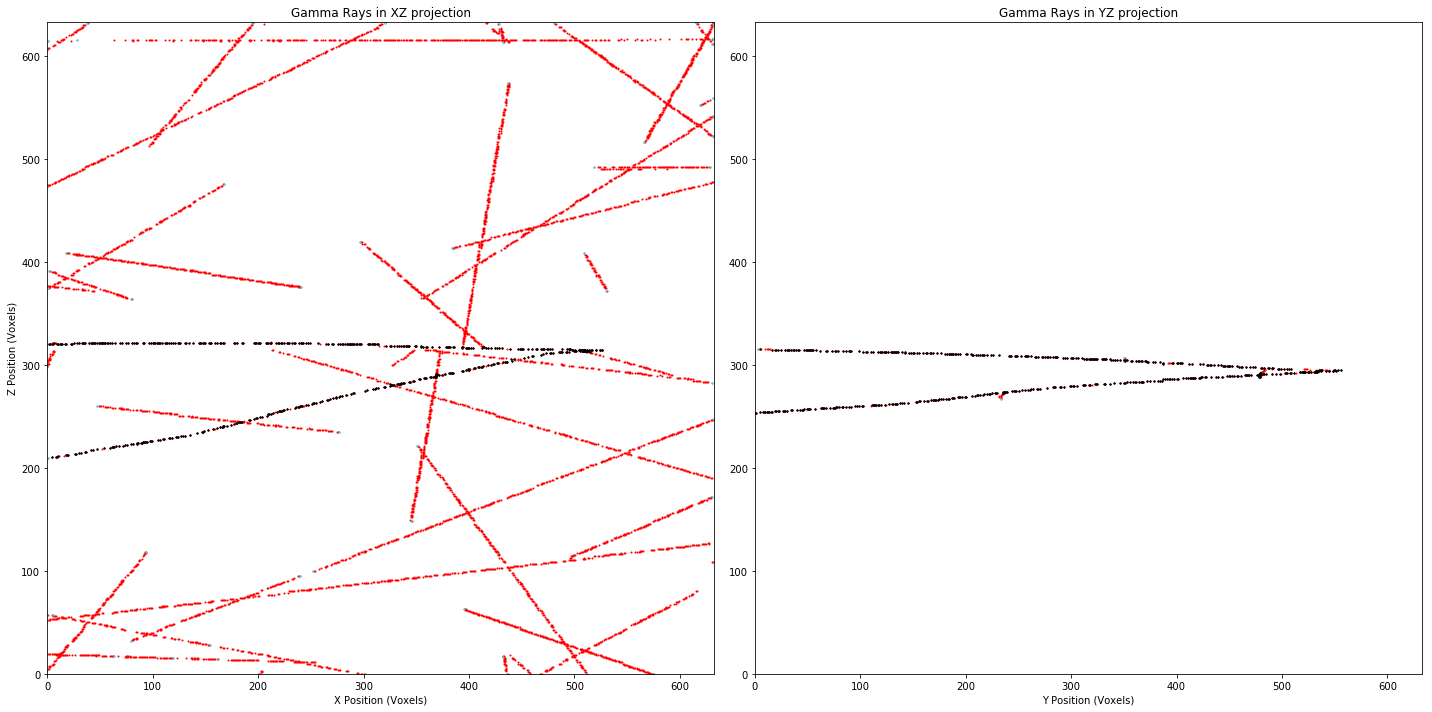

In [38]:
figure_init_segs, (ax_init_segs_XZ, ax_init_segs_YZ) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the detector hits
ax_init_segs_XZ.plot(hits_XZ[:,0], hits_XZ[:,1], '.', ms=2, color='red') 
ax_init_segs_YZ.plot(hits_YZ[:,0], hits_YZ[:,1], '.', ms=2, color='red')
ax_init_segs_XZ.plot(terminate_XZ[:,0], terminate_XZ[:,1], '.', ms=2, color='cyan') 
ax_init_segs_YZ.plot(terminate_YZ[:,0], terminate_YZ[:,1], '.', ms=2, color='cyan')

# Plot track hits
for i in range(len(gammas_XZ)):
    ax_init_segs_XZ.plot(gammas_XZ[i][:,0], gammas_XZ[i][:,1], '.', ms=2, color='black')
for i in range(len(gammas_YZ)):
    ax_init_segs_YZ.plot(gammas_YZ[i][:,0], gammas_YZ[i][:,1], '.', ms=2, color='black')
    
# Set axis limits
ax_init_segs_XZ.set_xlim(0, rows_XZ)
ax_init_segs_XZ.set_ylim(0, columns_XZ)
ax_init_segs_YZ.set_xlim(0, rows_YZ)
ax_init_segs_YZ.set_ylim(0, columns_YZ)

# Set labels
ax_init_segs_XZ.set_xlabel('X Position (Voxels)')
ax_init_segs_YZ.set_xlabel('Y Position (Voxels)')
ax_init_segs_XZ.set_ylabel('Z Position (Voxels)')

# Set titles
ax_init_segs_XZ.set_title('Gamma Rays in XZ projection')
ax_init_segs_YZ.set_title('Gamma Rays in YZ projection')

plt.tight_layout() # Spaces titles out properly

# Save figure 
file_init_segs_XZYZ ='Gammas_XZYZ.pdf'
plt.savefig(file_init_segs_XZYZ)
print('Saving image of track hits to: ' + file_init_segs_XZYZ)

plt.show(figure_init_segs)